# Task05 Node2Vec论文精读

## 1 Node2Vec简介

### 1.1 Graph Embedding图嵌入

- 图嵌入：将图中的节点node映射到D维向量vector，D维向量具有低维、连续（元素都是实数）、稠密（每个元素都不为0）
- 应用场景：节点分类、连接预测、图分类、异常检测、聚类等
- 图嵌入分类：节点、边、子图、全图
- 图嵌入方法：基于手工构造特征、基于矩阵分解、基于随机游走、基于图神经网络

### 1.2 DeepWalk缺点

- 用完全随机游走，训练节点嵌入向量，仅能反映**相邻**节点的**社群相似信息**，无法反映节点的**功能角色**相似信息

### 1.3 Node2Vec

- Node2Vec是有偏的随机游走：
    - 当$\displaystyle \alpha=\frac{1}{p}$时，当前节点返回上一个节点
    - 当$\alpha = 1$时，当前节点徘徊
    - 当$\displaystyle \alpha = \frac{1}{q}$时，当前节点远行

- 当$p$值很小时，属于广度优先搜索，反映微观的邻域
- 当$q$值很小时，属于深度优先搜索，反映宏观的视角

- DFS：同质社群（homophily）（社交网络）
- BFS：节点功能角色（structural equivalence）（中枢、桥接、边缘）

- Node2Vec属于二阶随机游走（二阶马尔科夫），取决于当前点的位置和上一个节点
- 当$p$大$q$小时，属于DFS深度优先，探索远方
- 当$p$小$q$大时，属于BFS宽度优先，探索邻域

- 步骤：
    1. 生成随机游走采样策略
    2. 每个节点生成$r$个随机游走序列，即生成训练集
    3. 使用上述训练集，通过Skip-Gram训练得到节点嵌入表示

- Node2Vec：
    - 解决图嵌入问题，将图中的每个节点映射为一个向量（嵌入）
    -  向量（嵌入）包含了节点的语义信息（相邻社群和功能角色）
    - 语义相似的节点，向量（嵌入）的距离也近
    - 向量（嵌入）用于后续的分类、聚类、Link Prediction、推荐等任务
    - 在DeepWalk完全随机游走的基础上，Node2Vec增加参数p和q，实现有偏随机游走。不同的p、q组合，对应了不同的探索范围和节点语义
    - DFS深度优先探索，相邻的节点，向量（嵌入）距离相近
    - BFS广度优先探索，相同功能角色的节点，向量（嵌入）距离相近
    - DeepWalk是Node2Vec在p=1，q=1的特例

## 2 Node2Vec论文精读

论文来源：《node2vec：Scalable Feature Learning for Networks》（Node2Vec：可扩展的图嵌入表示学习算法）

### 2.1 摘要

- 背景：通过表示学习，可以将图中的节点和连接转化为向量，但这些表示方法（DeepWalk、LINE）无法表示网络中节点多样性的连接属性。
- 通过Node2Vec，可以将节点映射到低维、连续、稠密的向量，使用极大似然估计进行训练，并通过有偏的随机游走，灵活地探索节点的多样性，可是用于通用特征表示。

### 2.2 介绍

- 背景：节点和边的预测包含很多任务，如节点分类问题（社交网络、蛋白质分类）、连接预测任务（基因组学、社交网络），为解决上述问题，可以通过设计人工特征，也可采用机器学习的表示学习，包含有监督（针对特定任务优化）、无监督（Word2Vec、Glove），对于无监督学习而言是不满足的，故提出矩阵分解（无法应用在规模更大数据集上）和随机游走（BFS、DFS策略）的方法；针对随机游走算法，需要考虑社群的相似，也要考虑功能角色的相似。

- Node2Vec是半监督算法，使用SGD方法优化，使用极大似然估计进行训练，采样方法使用二阶随机游走（二阶马尔科夫性，下一个节点不仅与当前节点有关，还与上一个节点有关），比DeepWalk、LINE的效果都要好。

- 贡献：
    1. Node2Vec可以通过调节p、q探索图的不同特性，使用SGD进行优化，使用极大似然估计基于中间节点预测周围节点
    2. Node2Vec符合网络科学的准则，提取的特征包含了丰富的语义信息
    3. 将节点嵌入拓展到了连接嵌入
    4. 在多类别分类数据集和节点预测数据集上进行了大量实验

### 2.3 相关工作

- 传统方法的缺点：基于手工设计特征的图嵌入，该方式不通用；为解决该问题，通过机器学习的表示学习，自动获得每个节点的嵌入特征；基于矩阵分解的图嵌入，例如Laplacian矩阵、PCA方法，该方法计算很难，并且也不通用。
- 基于随机游走的图嵌入：Skip-Gram、DeepWalk和LINE用中间词预测周围词的方式，但缺少采样策略
- 基于监督学习的图嵌入：用节点的标签进行图嵌入，直接优化下游任务的损失函数，没有进行预嵌入

### 2.4 算法框架

- 假设：图$G=(V,E)$，其中学习到的映射设为$f:V \rightarrow \mathbb{R}^d$，邻域节点设为$N_S(u) \subset V$，采样策略设为$S$

- Skip-Gram损失函数：
$$
\max \limits_f \sum_{u \in V} \log Pr(N_S(u) | f(u))
$$

- 简化假设：
    - 条件独立（周围节点互不影响）：
    $$
    Pr(N_S(u)|f(u)) = \prod_{n_i \in N_S(u)} Pr(n_i | f(u))
    $$
    - 对称性（两个节点之间互相影响的程度一样）：
    $$
    Pr(n_i | f(u)) = \frac{\exp (f(n_i) \cdot f(u))}{\displaystyle \sum_{v \in V} \exp (f(v) \cdot f(u))}
    $$

- Skip-Gram损失函数（简化）：
$$
\max \limits_f \sum_{u \in V} \left[ -\log Z_u + \sum_{n_i \in N_S(u)} f(n_i) \cdot f(u) \right]
$$
其中
$$
Z_u = \sum_{v \in V} \exp (f(u) \cdot f(v))
$$

#### 2.4.1 传统搜索策略

- DFS：同质社群（homophily）（社交网络）
- BFS：节点功能角色（structural equivalence）（中枢、桥接、边缘）
- 一个网络中可能同时存在上述两种策略

#### 2.4.2 Node2Vec

- 符号说明：
    - $u$：起始点
    - $v$：当前节点
    - $x$：下一个节点
    - $t$：上一个节点
    - $N_S(t)$：上一个节点的邻域节点
    - $k$：当前节点$v$的领域节点个数
    - $l$：随机游走序列节点个数

- Random Walks：
$$
P(c_i = x | c_{i-1} = v) = 
\left \{ 
\begin{array}{ll} 
\displaystyle \frac{\pi_{vx}}{Z} & \text{if} \ (v, x) \in E \\
0 & \text{otherwise}
\end{array} 
\right \}
$$
其中，$\pi_{vx}$为连接的权重，$Z$是归一化常数。

- 有偏 $\alpha$ 搜索：下一个时刻的状态与当前状态和上一个状态有关，称为二阶马尔科夫
$$
\alpha_{pq}(t, x) = \left \{ 
\begin{array}{ll}
\displaystyle \frac{1}{p} & \text{if} \ d_{tx} = 0 \\
1 & \text{if} \ d_{tx} = 1 \\
\displaystyle \frac{1}{q} & \text{if} \ d_{tx} = 2
\end{array}
\right .
$$
其中，$d_{tx}$为从$t$到$x$的最短路径长度。

- 空间复杂度：$O(a^2 |V|)$
- 时间复杂度：$\displaystyle O \left( \frac{l}{k(l-k)} \right)$

#### 2.4.3 Node2Vec算法

> **LearnFeature** (Graph $G=(V, E, W)$, Dimensions $d$, Walks per node $r$, Walk length $l$, Context size $k$, Return $p$, In-out $q$)  
&emsp;$\pi = \text{PreprocessModifiedWeights(G, p, q)}$（生成随机游走采样策略）  
&emsp;$G' = (V, E, \pi)$  
&emsp;Initialize $walks$ to Empty  
&emsp;for iter = 1 to $r$ do（每个节点生成$r$个随机游走序列）  
&emsp;&emsp;for all nodes $u \in V$ do  
&emsp;&emsp;&emsp;$walk = \text{node2vecWalk}(G', u, l)$（生成$l$个随机游走序列）  
&emsp;&emsp;&emsp;Append $walk$ to $walks$  
&emsp;$f = \text{StochasticGradientDescent}(k, d, walks)$（Skip-Gram训练得到节点嵌入表示）  
&emsp;return $f$ 

> **node2vecWalk** (Graph $G'=(V, E, \pi)$, Start node $u$, Length $l$)  
&emsp;Initialize $walk$ to $[u]$  
&emsp;for $walk_iter = 1$ to $l$ do  
&emsp;&emsp;$curr = walk[-1]$  
&emsp;&emsp;$V_curr = \text{GetNeighbors}(curr, G')$  
&emsp;&emsp;$s = \text{AliasSample}(V_{curr}, \pi)$（根据采样策略，找到下一个节点）  
&emsp;&emsp;Append $s$ to $walk$  
&emsp;return $walk$

- Alias Sample：用于产生下一个随机游走节点，时间复杂度为$O(1)$，用空间（预处理）换时间，适用于大量反复的抽样情况下，将离散分布抽样转化为均匀分布抽样

- 当$p$大$q$小时，属于DFS深度优先，探索远方
- 当$p$小$q$大时，属于BFS宽度优先，探索邻域

## 3 Node2Vec代码实战

### 3.1 导入工具包

In [1]:
import networkx as nx
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

### 3.2 加载数据集

In [2]:
# 《悲惨世界》人物数据集
G = nx.les_miserables_graph()

### 3.3 构建Node2Vec模型

In [4]:
from node2vec import Node2Vec

# 设置node2vec参数
node2vec = Node2Vec(
    G, 
    dimensions=32,  # 嵌入维度
    p=1,            # 回家参数
    q=3,            # 外出参数
    walk_length=10, # 随机游走最大长度
    num_walks=600,  # 每个节点作为起始节点生成的随机游走个数
    workers=4       # 并行线程数
)

# p=1, q=0.5, n_clusters=6。DFS深度优先搜索，挖掘同质社群
# p=1, q=2, n_clusters=3。BFS宽度优先搜索，挖掘节点的结构功能。

# 训练Node2Vec
model = node2vec.fit(
    window=3,     # Skip-Gram窗口大小
    min_count=1,  # 忽略出现次数低于此阈值的节点（词）
    batch_words=4 # 每个线程处理的数据量
)
X = model.wv.vectors

Computing transition probabilities:   0%|          | 0/77 [00:00<?, ?it/s]

### 3.4 节点Embedding聚类可视化

In [5]:
# KMeans聚类
from sklearn.cluster import KMeans
import numpy as np
cluster_labels = KMeans(n_clusters=3).fit(X).labels_
print(cluster_labels)

[2 2 2 2 2 0 0 2 0 1 0 0 2 2 2 2 0 2 2 0 2 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 0
 2 2 0 2 2 0 2 0 0 0 2 0 2 2 2 2 0 2 2 2 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


In [6]:
# 将networkx中的节点和词向量中的节点对应
colors = []
nodes = list(G.nodes)
# 按 networkx 的顺序遍历每个节点
for node in nodes:
    # 获取这个节点在 embedding 中的索引号
    idx = model.wv.key_to_index[str(node)] 
    # 获取这个节点的聚类结果
    colors.append(cluster_labels[idx]) 

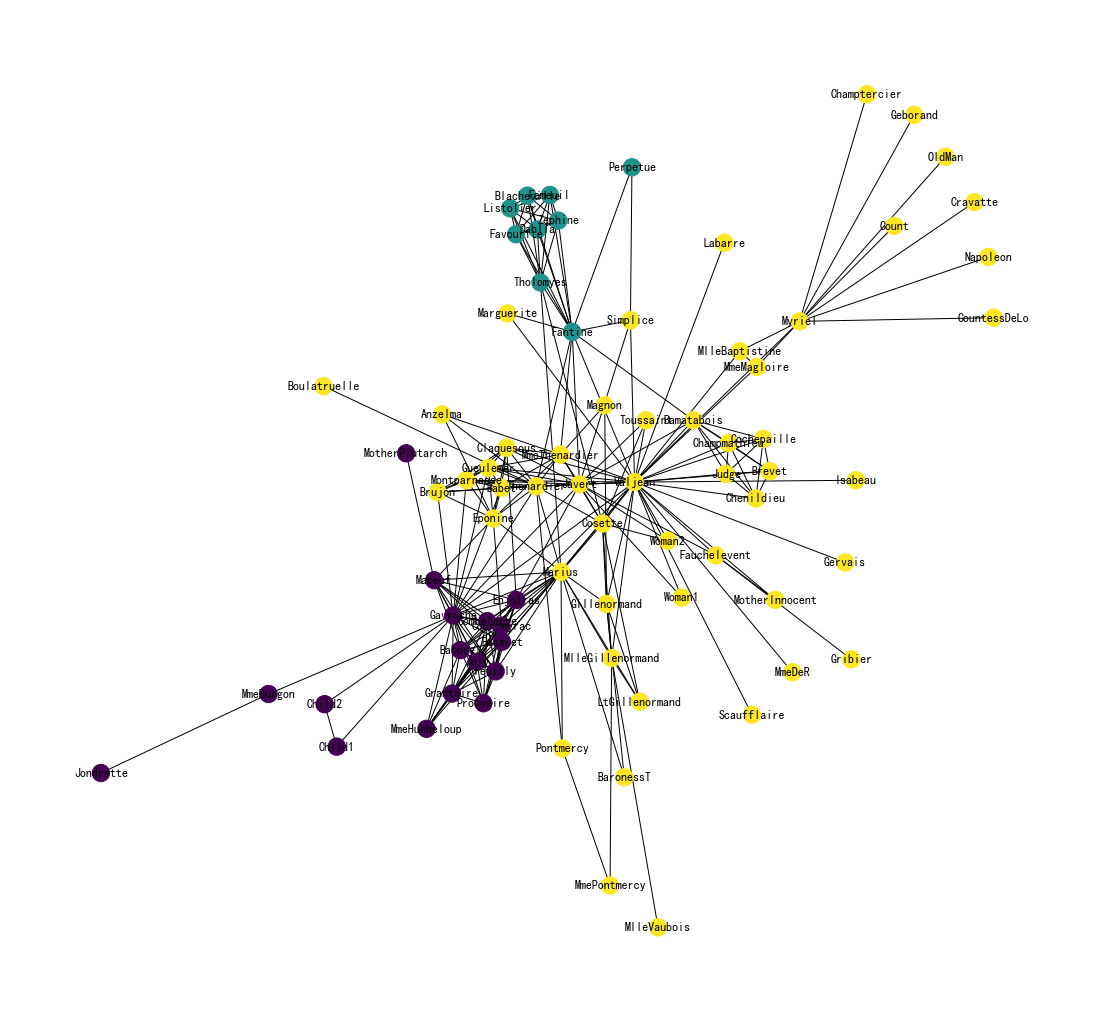

In [7]:
# 可视化聚类效果
plt.figure(figsize=(15,14))
pos = nx.spring_layout(G, seed=10)
nx.draw(G, pos, node_color=colors, with_labels=True)
plt.show()

### 3.5 节点Embedding降维可视化

In [8]:
# 将Embedding用PCA降维到2维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

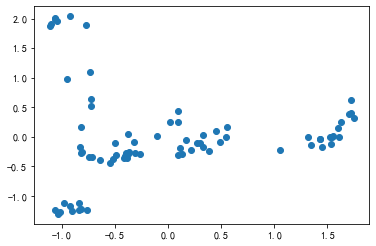

In [9]:
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
plt.show()

### 3.6 对Edge（连接）做Embedding

In [10]:
from node2vec.edges import HadamardEmbedder

# Hadamard 二元操作符：两个 Embedding 对应元素相乘
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# 查看 任意两个节点连接 的 Embedding
edges_embs[('Napoleon', 'Champtercier')]

array([ 3.2879427e-01,  8.3664991e-04,  9.2848742e-01,  2.1308610e-01,
        1.6506474e-01,  4.2615908e-01,  1.4483131e-01,  9.1942376e-01,
        2.6168872e-03,  8.2091503e-03,  1.7174059e-01,  2.6298312e-02,
       -4.7506350e-03, -1.9894931e-03,  5.6435197e-04,  2.2592463e-01,
        8.6000701e-03,  2.0368297e-01,  8.0734557e-03,  5.7401187e-03,
        5.0373960e-02,  1.5202832e-01,  8.6663896e-01,  8.0299474e-02,
        1.2431966e-01,  1.7634184e-03,  6.2732413e-02,  5.9891838e-01,
        4.6547554e-02,  6.8373844e-02,  1.9266235e-02,  8.8145651e-02],
      dtype=float32)

In [11]:
# 计算所有 Edge 的 Embedding
edges_kv = edges_embs.as_keyed_vectors()

Generating edge features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3003/3003.0 [00:00<00:00, 272931.05it/s]


In [12]:
# 查看与某两个节点最相似的节点对
edges_kv.most_similar(str(('Bossuet', 'Valjean')))

[("('Bahorel', 'Valjean')", 0.9378696084022522),
 ("('Combeferre', 'Valjean')", 0.9343024492263794),
 ("('Prouvaire', 'Valjean')", 0.9037362337112427),
 ("('Enjolras', 'Valjean')", 0.8992067575454712),
 ("('Courfeyrac', 'Valjean')", 0.8922621011734009),
 ("('Joly', 'Valjean')", 0.8789597749710083),
 ("('Grantaire', 'Valjean')", 0.8729923963546753),
 ("('Feuilly', 'Valjean')", 0.8643959760665894),
 ("('Mabeuf', 'Valjean')", 0.7931575179100037),
 ("('Combeferre', 'Woman1')", 0.787353515625)]

## 4 本章总结

本章主要讲了Node2Vec算法，包括：

- Node2Vec简介：回顾Graph Embedding图嵌入、DeepWalk缺点和Node2Vec简要讲解
- Node2Vec论文精读：Node2Vec是半监督算法，使用SGD方法优化，并使用极大似然估计进行训练，采样方法基于二阶随机游走
- Node2Vec代码实战：使用内置的悲惨世界数据集，构建Node2Vec模型，进行节点Embedding聚类和降维可视化，对Edge（连接）做Embedding